In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from models.ML import terrain_RF as trf

import utils as u
from models import pentzer2014pow
from visualization import multiline, papermode

# papermode(plt, size=12)

In [2]:
ugv_name = "husky"
saved_path = Path("data") / "saved_models"
model_name = trf.TerrainRFClassifier.model_name().lower()
figdir = u.get_figdir("summary", subdir=model_name)
model_name = trf.TerrainRFClassifier.filename()
ugv_mdl_path = saved_path / model_name / ugv_name

In [3]:
# terrain_abbrs = u.import_terrain_abbrs_yaml(("Till", "Vegetal", "Asphalt", "Snow"))
terrain_abbrs = u.import_terrain_abbrs_yaml(("Sandy loam", "Asphalt", "Snow", "Flooring", "Ice"))
terrain_abbrs = {terr:[abbr for abbr in terr_abbrs if u.get_ugv(abbr) == "husky"] for terr, terr_abbrs in terrain_abbrs.items()}
# terrain_abbrs = u.import_terrain_abbrs_yaml()
abbrs = sorted([item for sublist in terrain_abbrs.values() for item in sublist])
# abbrs = [abbr for abbr in abbrs if u.get_ugv(abbr) == "husky"]

In [4]:
dfs = {}
for abbr in abbrs:
    pentz_df = pentzer2014pow.open_model_df(abbr)
    dfs[abbr] = pentz_df
    dfs[abbr]["mass"] = pentz_df.meta.ugv_mass
    dfs[abbr]["terrain"] = u.get_terrain(abbr).lower()

In [5]:
# veloc = ("vx", "vy", "vz")
veloc = ("vx", )
accel_cor = ("ax_corr", "ay_corr", "az_corr")
posit = ("px", "py", "pz")
volts = ("V_L", "V_R")
wheel = ("vL", "vR")
morales = ("JS_sym", "JG")
amps = ("I_L", "I_R")

cols_x = [
    *veloc,
    *accel_cor,
    *volts,
    *wheel,
    *morales,
    *amps,
]

cols_y = ["terrain"]

In [6]:
terrain_dfs = {}
for terr, terr_abbrs in terrain_abbrs.items():
    terr_dfs = [dfs[abbr] for abbr in terr_abbrs]
    terrain_dfs[terr] = pd.concat(terr_dfs, ignore_index=True)
    terrain_dfs[terr]["terrain"] = terr

terr_df = pd.concat(terrain_dfs.values(), ignore_index=True)
terr_df = terr_df[cols_x + cols_y].copy().dropna()

In [7]:
X = terr_df[cols_x].copy()
y = terr_df[cols_y].copy()
terrain_summary = y.terrain.value_counts()
terrains = sorted(terrain_dfs.keys())
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [8]:
terrain_summary

ice           14849
flooring      13924
snow           9378
sandy loam     4347
asphalt        3695
Name: terrain, dtype: int64

# Model

In [9]:
rf_clf = trf.TerrainRFClassifier()
rf_clf.fit(X_train, y_train.terrain.values)

TerrainRFClassifier()

In [10]:
y_pred = rf_clf.predict(X_test)
rf_clf.score(X_test, y_test)


0.9571391462464283

# Metrics

In [11]:
y_true = y_test
y_pred = rf_clf.predict(X_test)
metrics = rf_clf.metrics(y_true, y_pred)
print(metrics)

Exporting metrics to /home/norlab/code/202206/terrain-code/metrics_ML.json
accuracy                                              0.957139
precision    [0.9106487148102815, 0.9495515695067265, 0.972...
recall       [0.8285077951002228, 0.9735632183908046, 0.979...
f1-score     [0.8676384839650146, 0.9614074914869466, 0.976...
dtype: object


['vx', 'ax_corr', 'ay_corr', 'az_corr', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


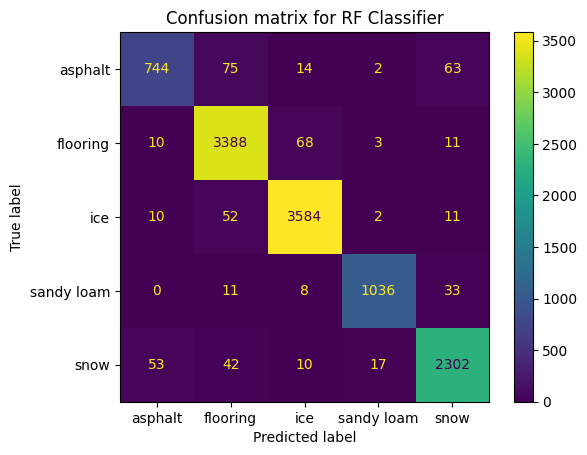

In [12]:
disp = rf_clf.confusion_matrix(y_test, y_pred)
print(cols_x)

['vx', 'ax_corr', 'ay_corr', 'az_corr', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


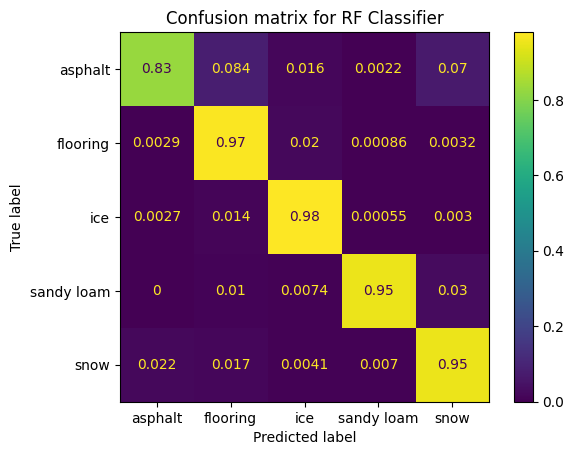

In [13]:
disp = rf_clf.confusion_matrix(y_test.terrain, y_pred, normalization="true", figdir=figdir)
print(cols_x)

In [14]:
rf_clf.export_model(ugv_mdl_path)

Exporting models in /home/norlab/code/202206/terrain-code/data/saved_models/balanced-rf-classifier/husky


In [15]:
pred_proba = rf_clf.predict_proba(X_test)
pred_proba

array([[0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.99, 0.  , 0.01],
       ...,
       [0.  , 0.  , 1.  , 0.  , 0.  ],
       [0.13, 0.76, 0.03, 0.  , 0.08],
       [0.01, 0.99, 0.  , 0.  , 0.  ]])

In [16]:
print(X_test.iloc[1])
print(rf_clf.predict([X_test.iloc[0]]).item())
print(y_test.iloc[0])

vx          0.000431
ax_corr    -0.296852
ay_corr    -0.522031
az_corr    -0.118857
V_L        21.480000
V_R        21.510000
vL         -0.149606
vR          0.149606
JS_sym     14.397304
JG          0.299213
I_L         9.000000
I_R         4.140000
Name: 12963, dtype: float64
ice
terrain    ice
Name: 45969, dtype: object


/home/norlab/code/202206/terrain-code/venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but TerrainRFClassifier was fitted with feature names
  warnings.warn(


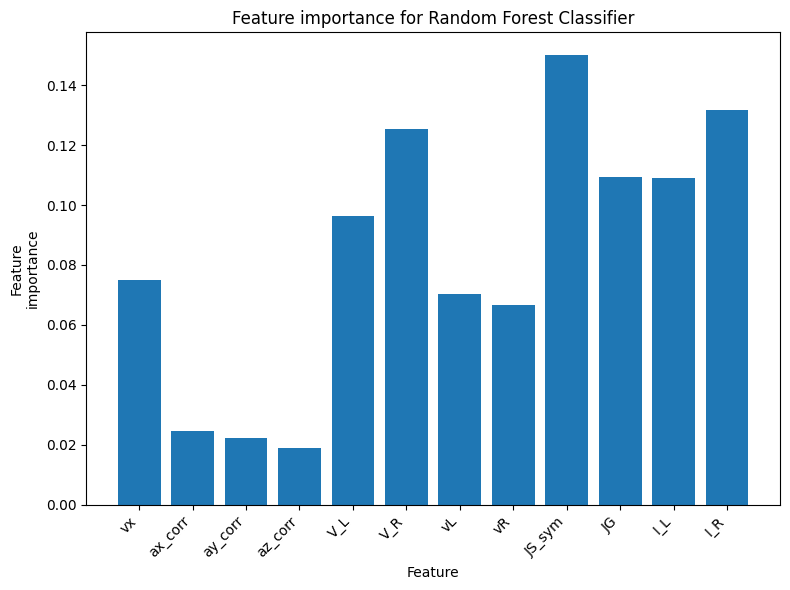

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(X_test.columns.values, rf_clf.feature_importances_)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("Feature")
ax.set_ylabel("Feature\nimportance")
ax.set_title("Feature importance for Random Forest Classifier")
fig.tight_layout()

In [18]:
if False:
    rf_clf.cross_val_metrics(X, y)

https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html

# Unseen data

In [19]:
unseen = pentzer2014pow.open_model_df("H74")
unseen["mass"] = unseen.meta.ugv_mass
unseen = unseen[cols_x + ["P_motion", "time_rel"]].copy().dropna()
unseen = unseen.dropna()

In [20]:
print(unseen.shape)
unseen.head()

(6290, 14)


vx   ax_corr   ay_corr   az_corr    V_L    V_R        vL  \
0 -2.254265e-16 -0.978097 -0.007367  0.049040  23.16  23.16  0.055118   
1  3.561989e-03 -1.104764 -0.102631  0.047878  23.06  22.99  0.173228   
2  2.780546e-02 -0.546486 -0.090610 -0.066458  22.92  22.92  0.220472   
3  3.611061e-02  0.482854  0.093764  0.075668  23.16  23.16  0.220472   
4  4.441576e-02 -0.053227 -0.068949 -0.015779  23.13  23.09  0.220472   

         vR    JS_sym        JG   I_L   I_R   P_motion  time_rel  
0  0.055118  3.332478  0.110236  0.00  5.19   5.334564  0.000000  
1  0.173228  1.733511  0.346457  1.64  6.76  27.135356  0.160083  
2  0.236220  1.085047  0.456693  1.91  6.37  35.913232  0.271713  
3  0.244094  3.731143  0.464567  0.00  3.88  17.661475  0.383233  
4  0.244094  2.310931  0.464567  0.00  4.01  18.253226  0.527148

In [21]:
X_unseen = unseen[cols_x].copy()
pred_unseen = rf_clf.predict_idx(X_unseen)
pred_unseen


array([4, 4, 4, ..., 4, 4, 4])

In [22]:
y_unseen = rf_clf.predict(X_unseen)

Text(0.5, 0, 'Elapsed time (s)')

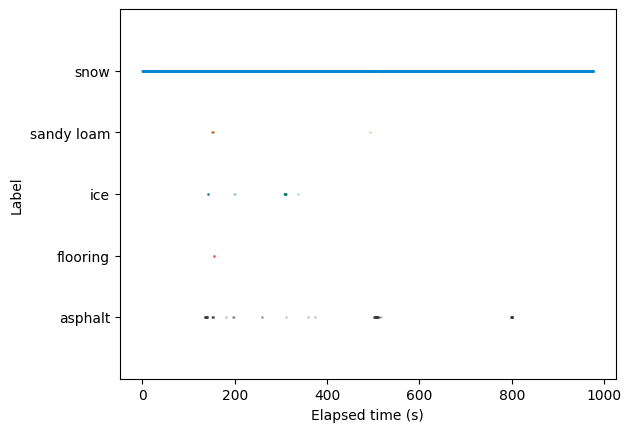

In [23]:
fig, ax = plt.subplots()

for idx, terr in enumerate(rf_clf.classes_):
    terr_idx = y_unseen == terr
    terr_time = unseen.time_rel.loc[terr_idx]
    terr_label = idx * np.ones(terr_time.shape)
    ax.plot(
        terr_time,
        terr_label,
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.2,
    )

ax.set_yticks(np.arange(rf_clf.len_classes()), rf_clf.classes_)

ax.set_ylim(bottom=-1, top=rf_clf.len_classes())
ax.set_ylabel("Label")
ax.set_xlabel("Elapsed time (s)")

# Balanced Terrain RF Classifier

In [24]:
brf_clf = trf.BalancedTerrainRFClassifier()
brf_clf.fit(X_train, y_train.terrain.values)

/home/norlab/code/202206/terrain-code/venv/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/norlab/code/202206/terrain-code/venv/lib/python3.10/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


BalancedTerrainRFClassifier()

In [25]:
y_pred = brf_clf.predict(X_test)
brf_clf.score(X_test, y_test)

0.9470949865789245

['vx', 'ax_corr', 'ay_corr', 'az_corr', 'V_L', 'V_R', 'vL', 'vR', 'JS_sym', 'JG', 'I_L', 'I_R']


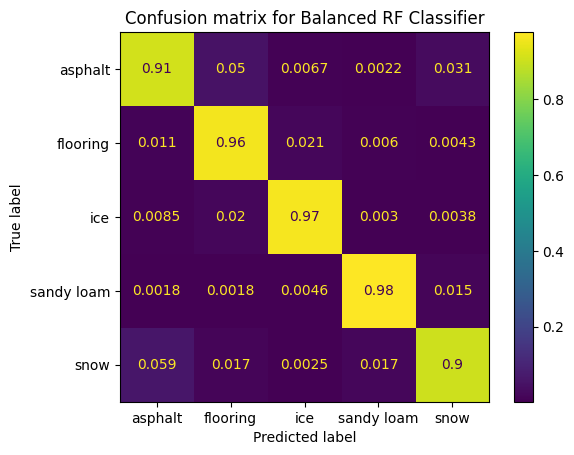

In [27]:
disp = brf_clf.confusion_matrix(y_test, y_pred, normalization="true")
print(cols_x)

In [28]:
X_unseen = unseen[cols_x].copy()
pred_unseen = brf_clf.predict_idx(X_unseen)
pred_unseen

array([4, 4, 4, ..., 4, 4, 4])

In [29]:
y_unseen = brf_clf.predict(X_unseen)

Text(0.5, 0, 'Elapsed time (s)')

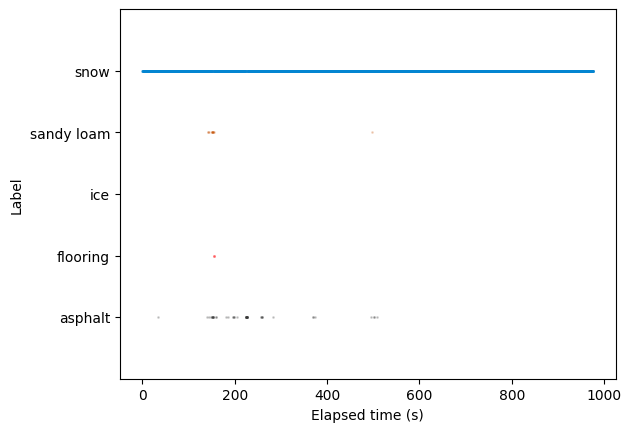

In [30]:
fig, ax = plt.subplots()

for idx, terr in enumerate(brf_clf.classes_):
    terr_idx = y_unseen == terr
    terr_time = unseen.time_rel.loc[terr_idx]
    terr_label = idx * np.ones(terr_time.shape)
    ax.plot(
        terr_time,
        terr_label,
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.2,
    )

ax.set_yticks(np.arange(brf_clf.len_classes()), brf_clf.classes_)

ax.set_ylim(bottom=-1, top=brf_clf.len_classes())
ax.set_ylabel("Label")
ax.set_xlabel("Elapsed time (s)")

# SMOTE

In [35]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)

"Original dataset shape Counter({'sandy loam': 14849, 'asphalt': 14849, 'snow': 14849, 'flooring': 14849, 'ice': 14849})"

In [37]:
rf_clf = trf.TerrainRFClassifier()
rf_clf.fit(X_train, y_train.terrain.values)

TerrainRFClassifier()

In [38]:
pred_unseen = rf_clf.predict_idx(X_unseen)
pred_unseen

array([4, 4, 4, ..., 4, 4, 4])

Text(0.5, 0, 'Elapsed time (s)')

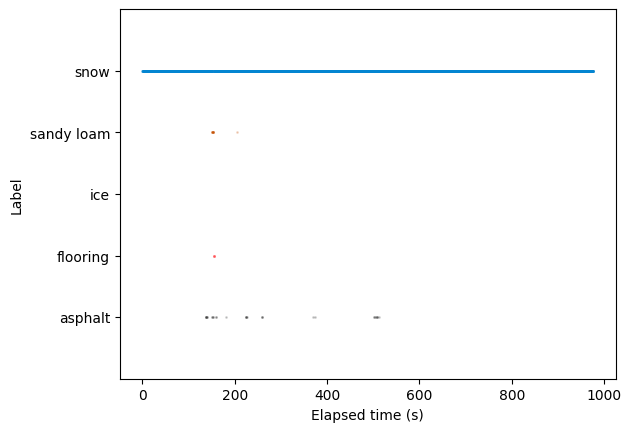

In [39]:
y_unseen = rf_clf.predict(X_unseen)
fig, ax = plt.subplots()

for idx, terr in enumerate(rf_clf.classes_):
    terr_idx = y_unseen == terr
    terr_time = unseen.time_rel.loc[terr_idx]
    terr_label = idx * np.ones(terr_time.shape)
    ax.plot(
        terr_time,
        terr_label,
        marker="o",
        linestyle="",
        markersize=1,
        label=terr,
        color=u.COLORS[terr],
        alpha=0.2,
    )

ax.set_yticks(np.arange(rf_clf.len_classes()), rf_clf.classes_)

ax.set_ylim(bottom=-1, top=rf_clf.len_classes())
ax.set_ylabel("Label")
ax.set_xlabel("Elapsed time (s)")